# Trajectory Visualization

Visualization of Gene Score, Expression and ChromVAR along trajectories.

Inputs:
1. ATAC metadata
2. ATAC pseudotime
3. ATAC ChromVAR
4. ArchR Gene Score
5. RNA Seurat object
6. RNA clusters (transfered from ATAC)
7. CCA or similar coembedding coordinates for ATAC+RNA
8. Cluster configs

In [1]:
library(Seurat)
library(ArchR)
library(RANN)
library(patchwork)
library(mgcv) # for smoothing

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [3]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [4]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Inputs

### ATAC MetaData

In [5]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 53906     6

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5      
                    cells              
D0_AACGCGAGAAGGACCA D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC D0_ACTCGCTACTTGTGAC

### Cluster Config

In [6]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster colour  description            new_cluster
1   1      #A6D854 Pre-iPSC               14         
2   2      #F0A118 Intermediate           12         
3   3      #E85F6D Fibroblast-like         3         
4   4      #006658 Neural-like             8         
5   5      #B03743 Fibroblast              1         
6   6      #CF175A Fibroblast-like         4         
7   7      #78A824 Pre-iPSC               13         
8   8      #F4D5CD Intermediate           11         
9   9      #D4B81C Intermediate            9         
10 10      #F01D35 Fibroblast-like         5         
11 11      #7C2730 Fibroblast-like         2         
12 12      #F7A6C2 Keratinocyte-like       6         
13 13      #406614 Partially-reprogrammed 10         
14 14      #F0520A Early intermediate      7

In [7]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### ArchR Gene Score

In [8]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow')
#              'H1.arrow')

In [9]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [10]:
all(paste(metaData$sample, metaData$barcode, sep='#') %in% archr_proj$cellNames)

[1] TRUE

In [11]:
# subset to cells
archr_proj = archr_proj[paste(metaData$sample, metaData$barcode, sep='#'), ]

In [12]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [13]:
archr_gene_score = getMatrixFromProject(archr_proj, "GeneScoreMatrix")
dim(archr_gene_score)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-1a364a45f03e-Date-2020-10-26_Time-06-19-03.log
If there is an issue, please report to github with logFile!

2020-10-26 06:20:27 : Organizing colData, 1.387 mins elapsed.

2020-10-26 06:20:27 : Organizing rowData, 1.388 mins elapsed.

2020-10-26 06:20:27 : Organizing Assays (1 of 1), 1.389 mins elapsed.

2020-10-26 06:21:12 : Constructing SummarizedExperiment, 2.141 mins elapsed.

2020-10-26 06:21:13 : Finished Matrix Creation, 2.162 mins elapsed.



[1] 24919 53906

In [14]:
archr_gene_score_mat = archr_gene_score@assays@data$GeneScoreMatrix
rownames(archr_gene_score_mat) = rowData(archr_gene_score)$name
colnames(archr_gene_score_mat) = sub("#", "_", rownames(colData(archr_gene_score)))
# reorder
archr_gene_score_mat = archr_gene_score_mat[, rownames(metaData)]

In [15]:
sum(is.na(archr_gene_score_mat))

[1] 0

In [16]:
# reclaim some memory
rm(archr_gene_score)
gc()

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   7895080  421.7   11519065   615.2   10217953   545.7
Vcells 649477231 4955.2 2130974944 16258.1 2201659211 16797.4

### Seurat Object

In [17]:
rna = readRDS("../20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")
rna$tech = "rna"

### ATAC-RNA Label Transfer

In [100]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

sample atac_cluster atac_new_cluster
AAACCCAAGAGTGACC-1 D0     5            1               
AAACCCAAGTGCCAGA-1 D0     5            1               
AAACCCACACCATTCC-1 D0     5            1               
AAACCCACACGCGTCA-1 D0     5            1               
AAACCCAGTCCATAGT-1 D0     5            1               
AAACCCAGTTATTCTC-1 D0     5            1

### ATAC Pseudotime

In [18]:
pseudotime = read.table("../20200217_trajectory/sessions/20201022_n53906/pseudotime.tsv")
rownames(pseudotime) = pseudotime$sample_barcode
pseudotime$sample_barcode = NULL
all(rownames(pseudotime) == rownames(metaData))
head(pseudotime)

[1] TRUE

dpt_pseudotime
D0_AACGCGAGAAGGACCA 0.00000000    
D0_AACGCGCTGTCTGTGA 0.20646924    
D0_ACCTATGGACTCGATA 0.17054172    
D0_ACGCAGAGATAACCCA 0.09116346    
D0_ACTCGCTACTTGTGAC 0.16613631    
D0_AGACTACTGGCAGTTT 0.05593833

### ChromVAR Scores

In [19]:
# Load ChromVAR (needs to be updated)
chromvar = read.table(gzfile("../20200607_ChromVAR/out/20200520_n68916/20200803_BPNet_hits.tsv"), 
                      sep='\t')
all(rownames(metaData) %in% rownames(chromvar))
# chromvar = chromvar[rownames(metaData),] # TODO
head(chromvar)

[1] FALSE

AP.1.bZIP. AP.2alpha.AP2. AP.2gamma.AP2. Ap4.bHLH. 
D0_AAACAACGACGATTAC 0.06062397 -0.19032848    -0.1806503     0.17649547
D0_AAACAACGAGCGCACT 0.12663771 -0.14932617    -0.1460632     0.13774811
D0_AAACACGCTACGCCAC 0.09179008 -0.27554985    -0.2684003     0.08156974
D0_AAACACGCTAGTACGG 0.22381185 -0.26024118    -0.2036954     0.19888174
D0_AAACACGCTCCTCAAA 0.09114996  0.03742272     0.0294599     0.51376057
D0_AAACACGCTCGAGTGA 0.27790548 -0.16897421    -0.1574511     0.02599568
                    Ascl2.bHLH. Atf1.bZIP. Atf2.bZIP. Atf3.bZIP. Atf4.bZIP. 
D0_AAACAACGACGATTAC  0.20330932 0.19744625 0.2751513  0.06082699  0.18974676
D0_AAACAACGAGCGCACT  0.08177252 0.09700864 0.2162815  0.12902809  0.16677545
D0_AAACACGCTACGCCAC  0.05768925 0.03807517 0.1018324  0.09991380 -0.06845765
D0_AAACACGCTAGTACGG  0.10450553 0.31782572 0.3421748  0.21633007  0.10552211
D0_AAACACGCTCCTCAAA  0.47133141 0.25353973 0.3047178  0.09847050  0.22350682
D0_AAACACGCTCGAGTGA -0.03327538 0.17291435 0.2474830  0.27188456  0.18969270
                    Atf7.bZIP. ⋯ TEAD3.TEA.   TEAD4.TEA.   Tlx..NR.   
D0_AAACAACGACGATTAC 0.25606442 ⋯  0.002451155  0.025287838  0.03428715
D0_AAACAACGAGCGCACT 0.11791373 ⋯ -0.179139154 -0.151820849  0.06055087
D0_AAACACGCTACGCCAC 0.08080772 ⋯  0.079465507  0.020082845 -0.05890462
D0_AAACACGCTAGTACGG 0.31998972 ⋯ -0.019393802  0.000957712 -0.08016259
D0_AAACACGCTCCTCAAA 0.26436031 ⋯  0.095798814  0.133782422  0.16927521
D0_AAACACGCTCGAGTGA 0.21165326 ⋯  0.071669620  0.092258454  0.08502060
                    WT1.Zf.     X.box.HTH.  YY1.Zf.      ZBTB18.Zf.
D0_AAACAACGACGATTAC -0.06157709  0.03630303  0.124991304  0.2653416
D0_AAACAACGAGCGCACT -0.13966197  0.22376462  0.138647337  0.2073126
D0_AAACACGCTACGCCAC -0.07673906 -0.01883431  0.003362537  0.1058641
D0_AAACACGCTAGTACGG -0.14234028  0.07883517  0.081795776  0.1828109
D0_AAACACGCTCCTCAAA  0.15624446  0.26249340  0.249567353  0.3349750
D0_AAACACGCTCGAGTGA -0.04936458 -0.06085424 -0.138721761 -0.0602405
                    ZBTB33.Zf.    Zic3.Zf.     ZNF143.STAF.Zf.
D0_AAACAACGACGATTAC  5.275922e-02 -0.001890931 -0.02174877    
D0_AAACAACGAGCGCACT -1.104272e-01 -0.065519777 -0.07611443    
D0_AAACACGCTACGCCAC  2.377935e-02  0.086366377 -0.06923392    
D0_AAACACGCTAGTACGG  1.008728e-02 -0.023485845  0.05765025    
D0_AAACACGCTCCTCAAA -1.091846e-01  0.064166909 -0.26921093    
D0_AAACACGCTCGAGTGA -5.107868e-05 -0.027740995 -0.06831649

### Coembedding 

In [20]:
head(colnames(rna))

[1] "AAACCCAAGAGTGACC-1" "AAACCCAAGTGCCAGA-1" "AAACCCACACCATTCC-1"
[4] "AAACCCACACGCGTCA-1" "AAACCCAGTCCATAGT-1" "AAACCCAGTTATTCTC-1"

In [21]:
coembedding = read.table("../20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.harmony.cca.tsv")

all(rownames(coembedding) == c(colnames(rna), rownames(metaData)))

dim(coembedding)
head(coembedding)

[1] TRUE

[1] 113275     16

tech harmony_1  harmony_2    harmony_3  harmony_4  
AAACCCAAGAGTGACC-1 rna  0.29773394  0.060780809 0.37018690  0.19983989
AAACCCAAGTGCCAGA-1 rna  0.28259904  0.029176483 0.24774358  0.21202861
AAACCCACACCATTCC-1 rna  0.19551768 -0.003477105 0.25965475  0.04794585
AAACCCACACGCGTCA-1 rna  0.09708915  0.025200052 0.19250754  0.15577251
AAACCCAGTCCATAGT-1 rna  0.14888114  0.085361749 0.05839939  0.03823448
AAACCCAGTTATTCTC-1 rna  0.19591517  0.007899533 0.23764734 -0.10709950
                   harmony_5   harmony_6   harmony_7   harmony_8   harmony_9  
AAACCCAAGAGTGACC-1  0.03008437  0.06041451  0.09856335  0.19131867  0.06073175
AAACCCAAGTGCCAGA-1 -0.01328118 -0.04644758  0.08735725  0.09445840  0.07126179
AAACCCACACCATTCC-1  0.00807158 -0.03565429  0.06622923  0.04148270 -0.15486719
AAACCCACACGCGTCA-1  0.02606344  0.07642032 -0.04095093 -0.08716850 -0.18003416
AAACCCAGTCCATAGT-1  0.21796512 -0.02450189 -0.03054403 -0.06001743 -0.03939952
AAACCCAGTTATTCTC-1 -0.16534263 -0.06857853  0.13958501 -0.02611316  0.04922825
                   harmony_10   harmony_11   harmony_12  harmony_13   
AAACCCAAGAGTGACC-1  0.075185428  0.002075287 -0.00138196  0.0696568031
AAACCCAAGTGCCAGA-1 -0.176678789  0.060986344 -0.06466362 -0.1243335302
AAACCCACACCATTCC-1 -0.072531205  0.099665928  0.24693218 -0.0141086953
AAACCCACACGCGTCA-1  0.090375417 -0.080367276  0.15396999  0.0728915400
AAACCCAGTCCATAGT-1 -0.002925019  0.009129636  0.34440203  0.1157595817
AAACCCAGTTATTCTC-1 -0.039199167  0.089413703  0.05449364 -0.0004101254
                   harmony_14  harmony_15 
AAACCCAAGAGTGACC-1  0.01121586  0.04240550
AAACCCAAGTGCCAGA-1 -0.14314382 -0.05377942
AAACCCACACCATTCC-1 -0.04370388 -0.24862321
AAACCCACACGCGTCA-1  0.05312232 -0.08005201
AAACCCAGTCCATAGT-1 -0.01071808 -0.22913379
AAACCCAGTTATTCTC-1 -0.47859847 -0.03039417

## Preprocessing

### Nearest Neighbor ATAC->RNA

In [22]:
# euclidean RNA NN for each ATAC cell
atac2rna_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)],
                    query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)],
                    10)

In [23]:
head(atac2rna_nn$nn.idx)

[,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9]  [,10]
[1,]  7056  7196  1484  5729  9280  4776  7151  1220  6470  1346
[2,]  1216  6577  6061  1278  7857  4663  5199  9973  1926  2187
[3,] 42036 40332 42444 50467 42530 36177 41241 36587 39118 33734
[4,]  5565     8  4874  1051  4556  3174  7564  2954  4567  5648
[5,] 14330 11287 14906 17867 16865 11237 16274 14157 17256 13112
[6,]   294  9317   220  7148  7160  1973  7898  7060  2041  9556

In [135]:
# or restrict to same cluster
K = 10
atac2rna_same_cluster_nn = matrix(0, nrow(metaData), K)
for (c in sort(unique(metaData$cluster_new_id))) {
    c2c_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)][atac.rna.label$atac_new_cluster == c, ],
                    query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)][metaData$cluster_new_id == c,],
                    K)$nn.idx
    
    orig_rna_idx = which(atac.rna.label$atac_new_cluster == c)
    
    # get original idx
    c2c_nn = matrix(orig_rna_idx[c2c_nn], nrow=nrow(c2c_nn))
        
    atac2rna_same_cluster_nn[metaData$cluster_new_id == c, ] = c2c_nn
}

## Plot

In [210]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 
}

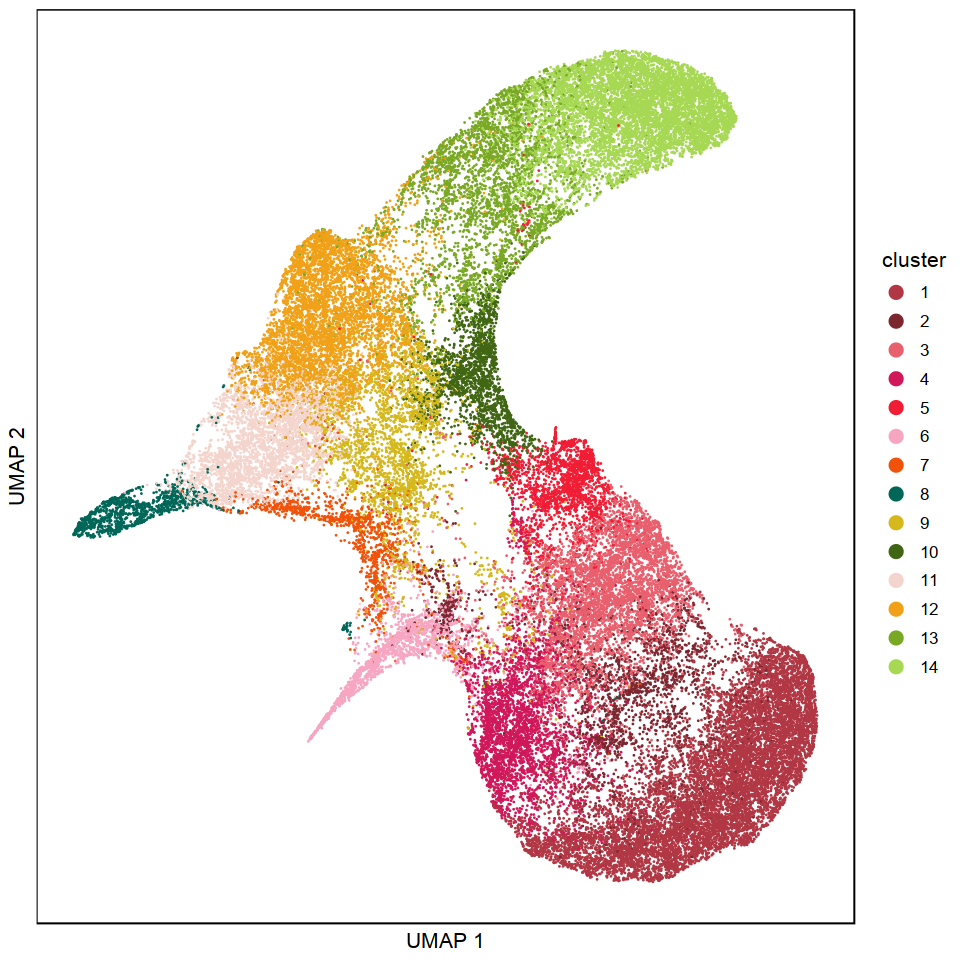

In [211]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id)) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

### Plot All Paths

In [233]:
ALL_PATHS = list(c(1,2,3,4,5), # non reprog
                c(1,6), # ker
                c(1,7,8), # neur
                c(1,7,9,10), # partial
                c(1,7,11,12,13,14)) #reprog


COLS = c("purple", "red", "blue", "tomato", "black")

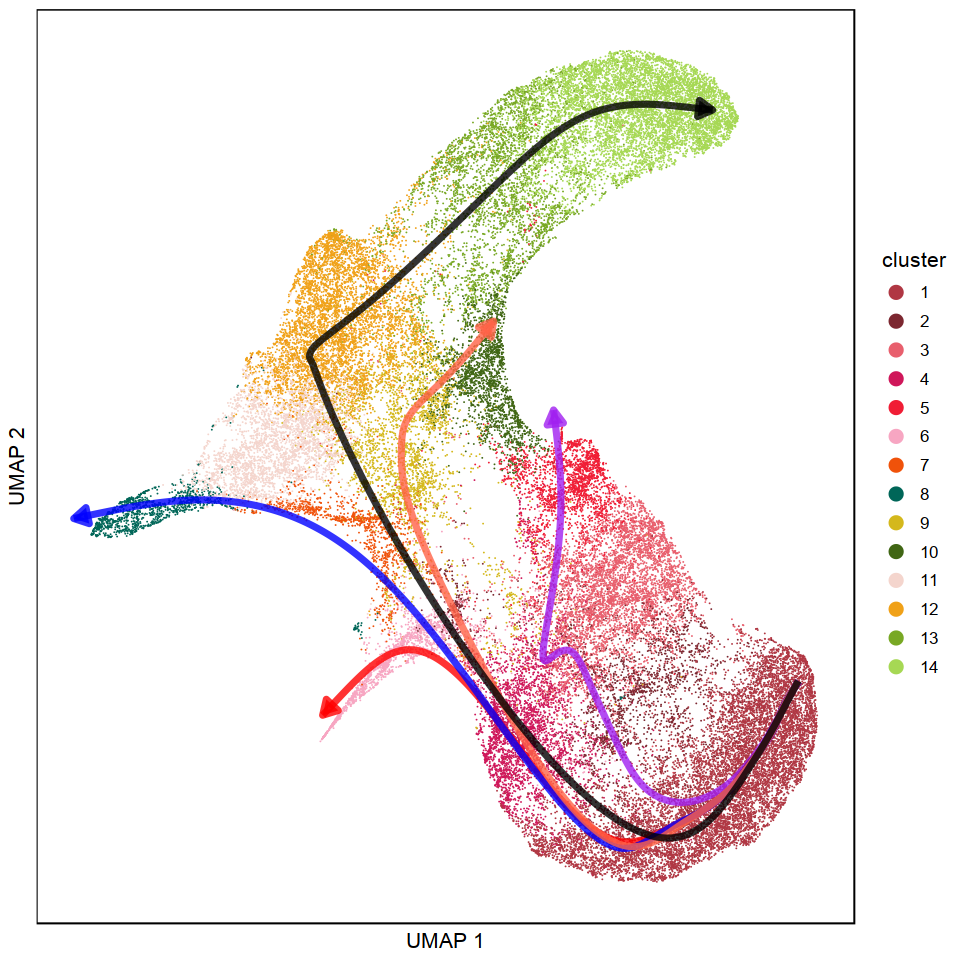

In [236]:
options(repr.plot.width = 8, repr.plot.height = 8)

path_plot <- plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id),
                        sz=0.25) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

for (i in seq(length(ALL_PATHS))) {
    selected = which(metaData$cluster_new_id %in% ALL_PATHS[[i]])
    path.df <- data.frame(x = smooth.spline(metaData$umap1[selected][order(pseudotime[selected,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[selected][order(pseudotime[selected,"dpt_pseudotime"])], df=200, spar=.9)$y)
    
    path_plot = path_plot + 
        geom_path(data=path.df, 
                  aes(x, y), 
                  size=1.5,
                  alpha=.8,
                  color=COLS[i], 
                  arrow=arrow(type="closed",
                              length=unit(.02, "npc")))
}

path_plot

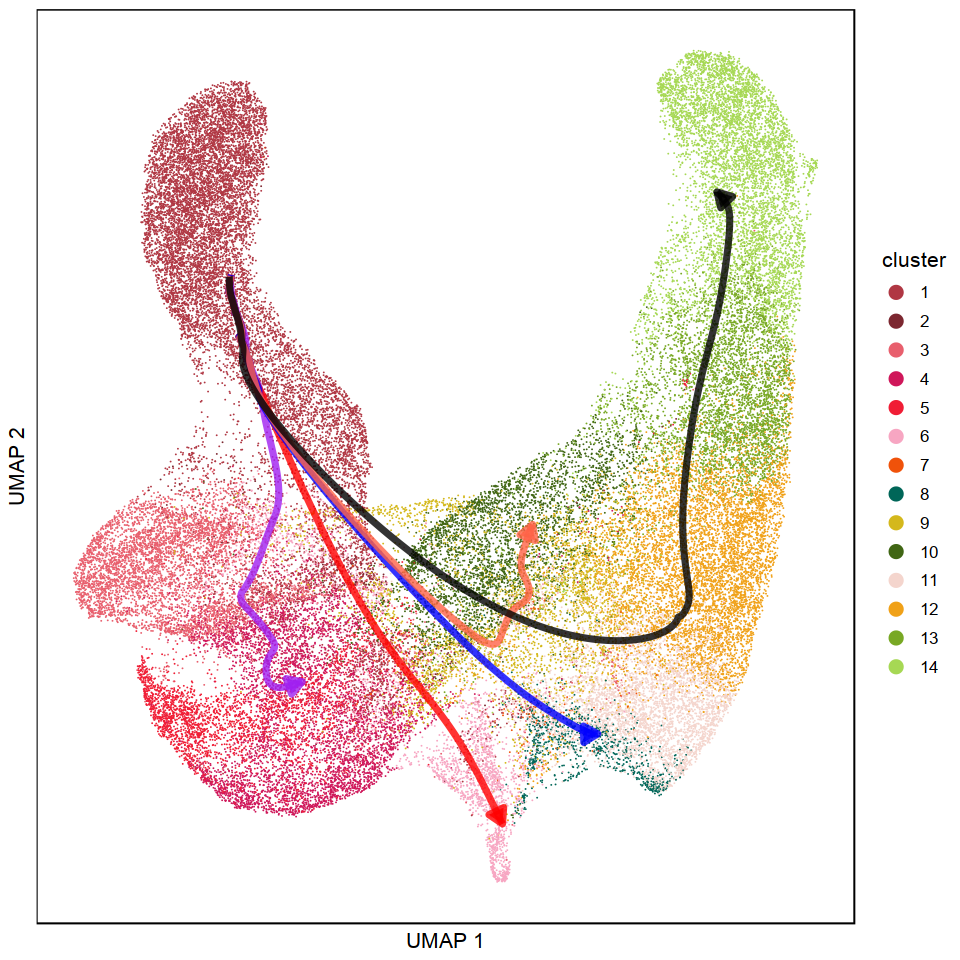

In [235]:
options(repr.plot.width = 8, repr.plot.height = 8)

path_plot <- plot_dimred(rna@reductions$umap@cell.embeddings[,1],
                         rna@reductions$umap@cell.embeddings[,2],
                         factor(atac.rna.label$atac_new_cluster),
                         sz=0.25) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

for (i in seq(length(ALL_PATHS))) {
    atac_selected = which(metaData$cluster_new_id %in% ALL_PATHS[[i]])
    rna_selected = atac2rna_same_cluster_nn[atac_selected, 1]
    
    path.df <- data.frame(x = smooth.spline(rna@reductions$umap@cell.embeddings[,1][rna_selected][order(pseudotime[atac_selected,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y, 
                        y = smooth.spline(rna@reductions$umap@cell.embeddings[,2][rna_selected][order(pseudotime[atac_selected,"dpt_pseudotime"])], 
                                          df=200, spar=.8)$y)
    
    path_plot = path_plot + 
        geom_path(data=path.df, 
                  aes(x, y), 
                  size=1.5,
                  alpha=.8,
                  color=COLS[i], 
                  arrow=arrow(type="closed",
                              length=unit(.02, "npc")))
}

path_plot

### Genes Along Pseudotime

In [237]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [246]:
RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
# RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [239]:
atac.path.df <- data.frame(x = smooth.spline(metaData$umap1[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y)

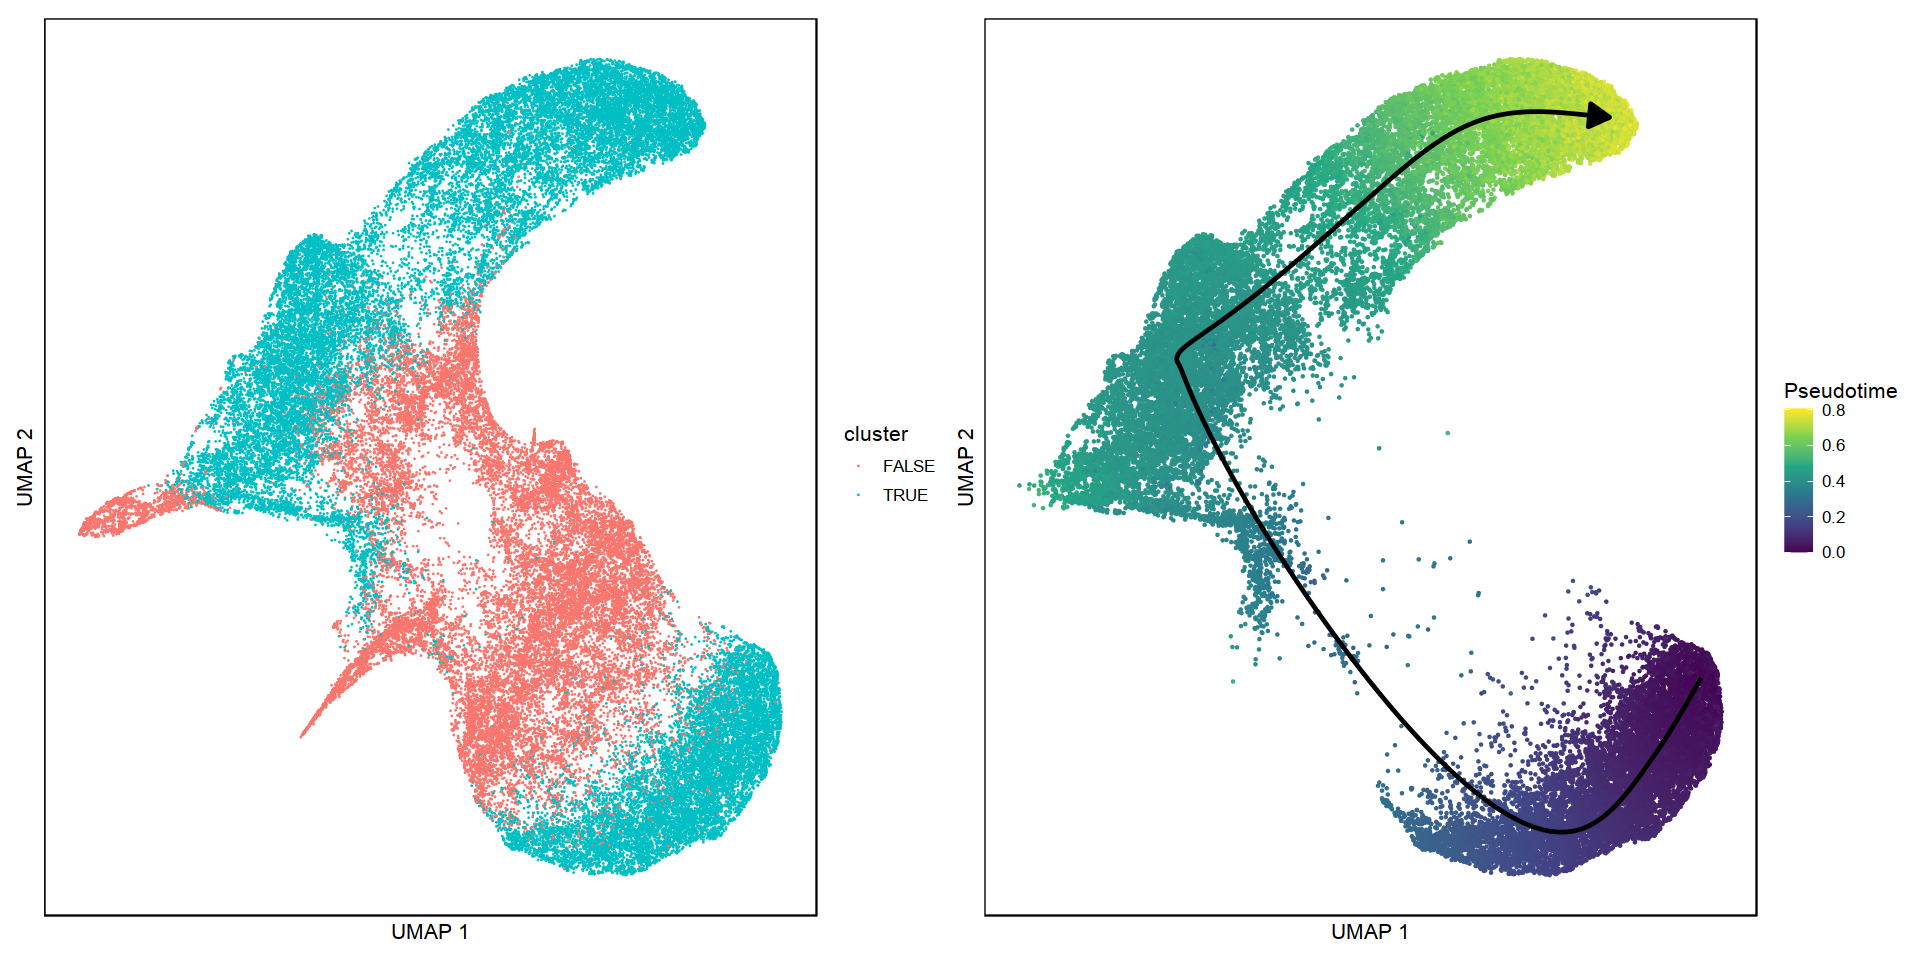

In [243]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(metaData$umap1,
           metaData$umap2,
           seq(nrow(metaData)) %in% ATAC_SEL)) |
(plot_dimred(metaData$umap1[ATAC_SEL],
           metaData$umap2[ATAC_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1) + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=atac.path.df, 
          aes(x, y), 
          size=1,
          color="black", 
          arrow=arrow(type="closed",
                     length=unit(.03, "npc"))))

In [247]:
rna.path.df <- data.frame(x = smooth.spline(rna@reductions$umap@cell.embeddings[,1][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y, 
                          y = smooth.spline(rna@reductions$umap@cell.embeddings[,2][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y)

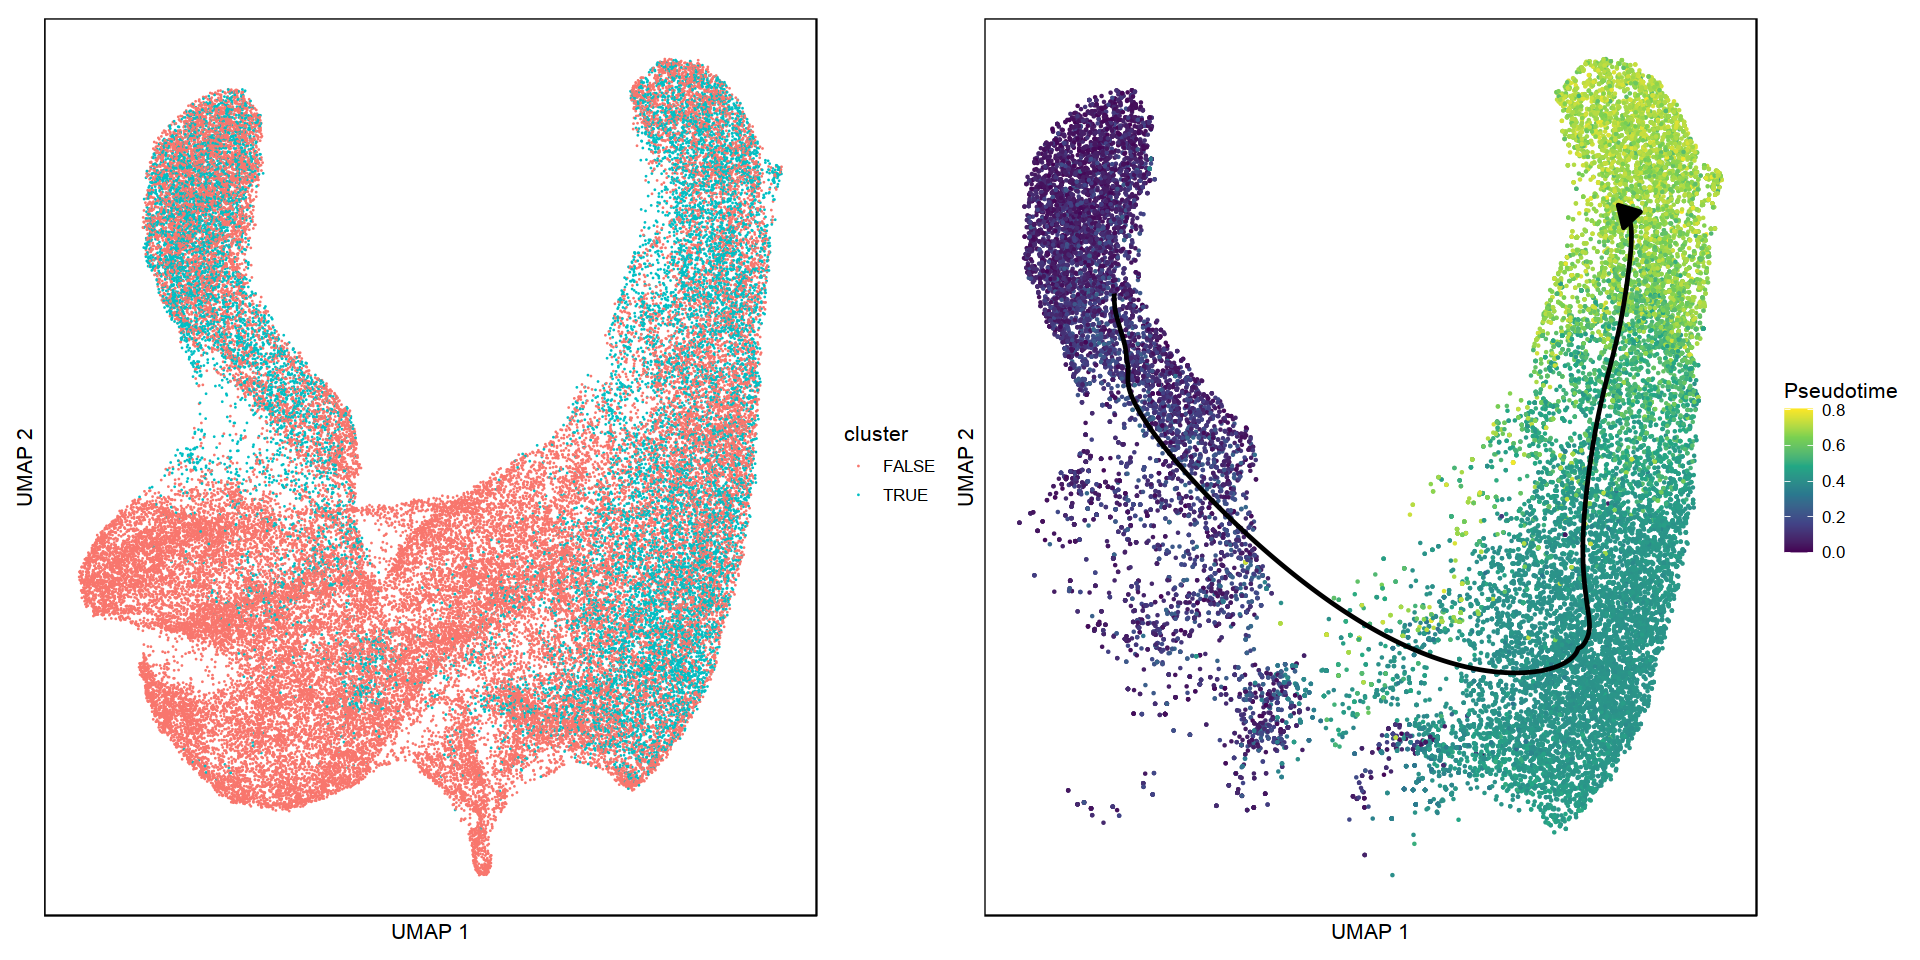

In [245]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(rna@reductions$umap@cell.embeddings[,1],
           rna@reductions$umap@cell.embeddings[,2],
           seq(ncol(rna)) %in% RNA_SEL)) |
(plot_dimred(rna@reductions$umap@cell.embeddings[,1][RNA_SEL],
           rna@reductions$umap@cell.embeddings[,2][RNA_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1)  + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=rna.path.df, 
      aes(x, y), 
      size=1,
      color="black", 
      arrow=arrow(type="closed",
                 length=unit(.03, "npc"))))

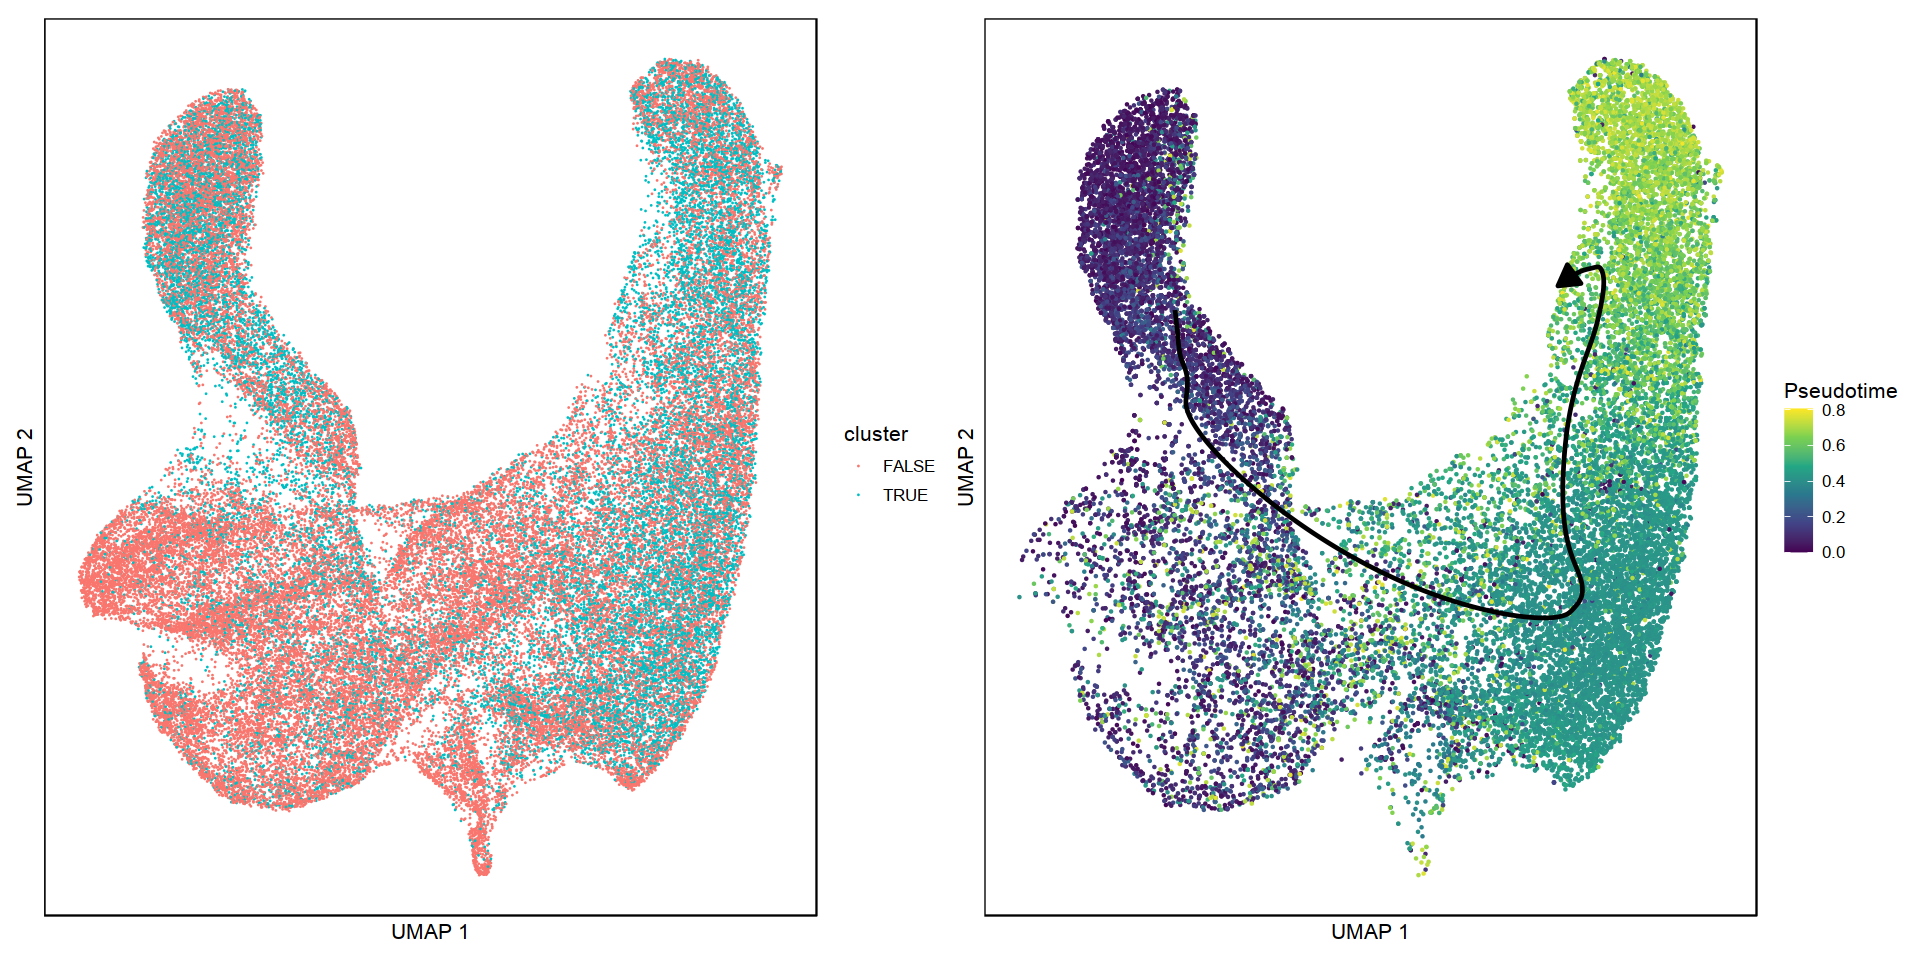

In [248]:
# without NN same cluster constraint
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(rna@reductions$umap@cell.embeddings[,1],
           rna@reductions$umap@cell.embeddings[,2],
           seq(ncol(rna)) %in% RNA_SEL)) |
(plot_dimred(rna@reductions$umap@cell.embeddings[,1][RNA_SEL],
           rna@reductions$umap@cell.embeddings[,2][RNA_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1)  + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=rna.path.df, 
      aes(x, y), 
      size=1,
      color="black", 
      arrow=arrow(type="closed",
                 length=unit(.03, "npc"))))

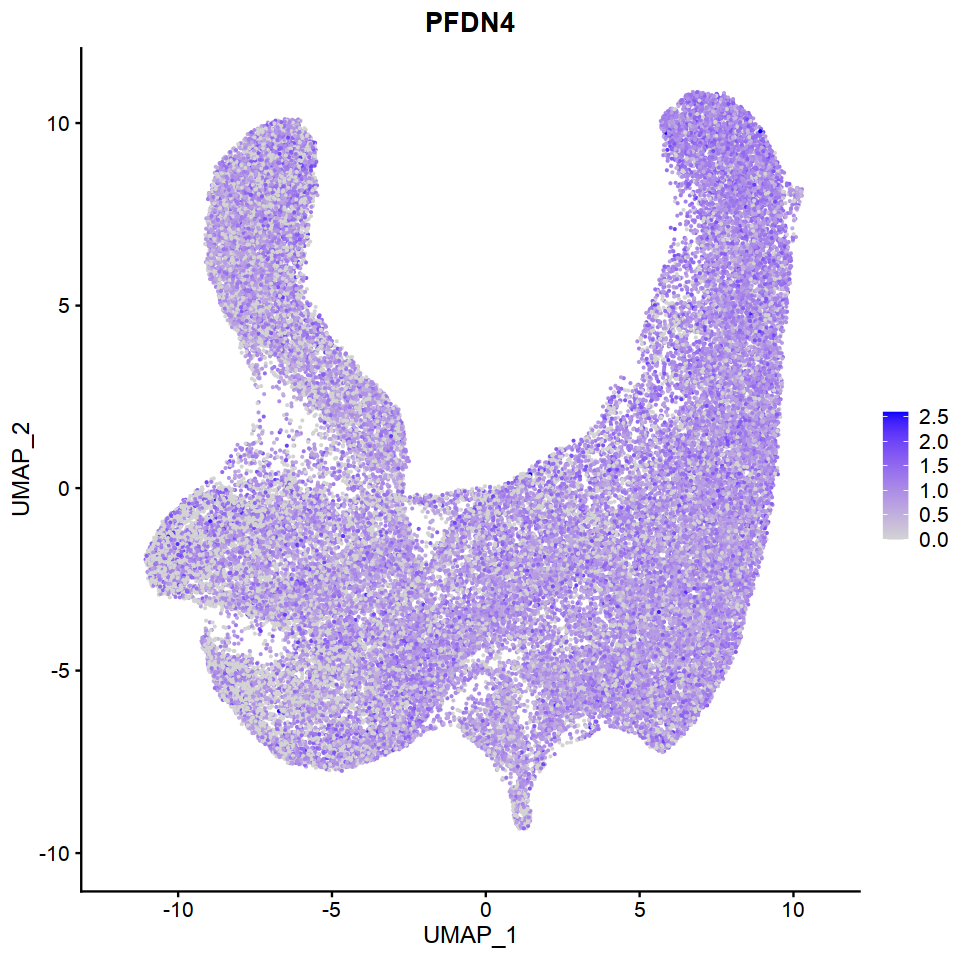

In [114]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna, features = c("PFDN4"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

In [506]:
GENE = "CTCF"
# print(colnames(chromvar)[grep(g, colnames(chromvar), ignore.case = T)])
# TF = colnames(chromvar)[grep(g, colnames(chromvar), ignore.case = T)][1]
# TF

In [507]:
colnames(chromvar)

[1] "AP.1.bZIP."                           
  [2] "AP.2alpha.AP2."                       
  [3] "AP.2gamma.AP2."                       
  [4] "Ap4.bHLH."                            
  [5] "Ascl2.bHLH."                          
  [6] "Atf1.bZIP."                           
  [7] "Atf2.bZIP."                           
  [8] "Atf3.bZIP."                           
  [9] "Atf4.bZIP."                           
 [10] "Atf7.bZIP."                           
 [11] "Atoh1.bHLH."                          
 [12] "Bach1.bZIP."                          
 [13] "Bach2.bZIP."                          
 [14] "BATF.bZIP."                           
 [15] "BORIS.Zf."                            
 [16] "c.Jun.CRE.bZIP."                      
 [17] "CEBP.bZIP."                           
 [18] "CRE.bZIP."                            
 [19] "CREB5.bZIP."                          
 [20] "CTCF.SatelliteElement.Zf.."           
 [21] "CTCF.Zf."                             
 [22] "E.box.bHLH."                          
 [23] "E2A.bHLH."                            
 [24] "EBF1.EBF."                            
 [25] "EKLF.Zf."                             
 [26] "Elk1.ETS."                            
 [27] "ERG.ETS."                             
 [28] "ETS.RUNX.ETS.Runt."                   
 [29] "ETS1.ETS."                            
 [30] "ETV4.ETS."                            
 [31] "Fos.bZIP."                            
 [32] "FOXA1.AR.Forkhead.NR."                
 [33] "Foxf1.Forkhead."                      
 [34] "FoxL2.Forkhead."                      
 [35] "Fra2.bZIP."                           
 [36] "GFX..."                               
 [37] "GFY.Staf...Zf."                       
 [38] "GRHL2.CP2."                           
 [39] "HEB.bHLH."                            
 [40] "HLF.bZIP."                            
 [41] "IRF1.IRF."                            
 [42] "IRF3.IRF."                            
 [43] "ISRE.IRF."                            
 [44] "Jun.AP1.bZIP."                        
 [45] "JunB.bZIP."                           
 [46] "JunD.bZIP."                           
 [47] "KLF1.Zf."                             
 [48] "KLF14.Zf."                            
 [49] "Klf4.Zf."                             
 [50] "KLF5.Zf."                             
 [51] "Mef2d.MADS."                          
 [52] "Myf5.bHLH."                           
 [53] "MyoD.bHLH."                           
 [54] "MyoG.bHLH."                           
 [55] "Nanog.Homeobox."                      
 [56] "NeuroG2.bHLH."                        
 [57] "NF.E2.bZIP."                          
 [58] "NF1.FOXA1.CTF.Forkhead."              
 [59] "NF1.CTF."                             
 [60] "NFAT.AP1.RHD.bZIP."                   
 [61] "NFkB.p65.Rel.RHD."                    
 [62] "NFkB.p65.RHD."                        
 [63] "NFY.CCAAT."                           
 [64] "NRF.NRF."                             
 [65] "NRF1.NRF."                            
 [66] "Nrf2.bZIP."                           
 [67] "OCT.OCT.POU.Homeobox."                
 [68] "Oct2.POU.Homeobox."                   
 [69] "OCT4.SOX2.TCF.NANOG.POU.Homeobox.HMG."
 [70] "Oct4.POU.Homeobox."                   
 [71] "Oct6.POU.Homeobox."                   
 [72] "Olig2.bHLH."                          
 [73] "PAX3.FKHR.fusion.Paired.Homeobox."    
 [74] "Pitx1.Ebox.Homeobox.bHLH."            
 [75] "PRDM1.Zf."                            
 [76] "Rbpj1..."                             
 [77] "REST.NRSF.Zf."                        
 [78] "RFX.HTH."                             
 [79] "Rfx1.HTH."                            
 [80] "Rfx2.HTH."                            
 [81] "Rfx5.HTH."                            
 [82] "Rfx6.HTH."                            
 [83] "Ronin.THAP."                          
 [84] "RUNX.AML.Runt."                       
 [85] "RUNX.Runt."                           
 [86] "RUNX1.Runt."                          
 [87] "RUNX2.Runt."                          


In [508]:
motif = "Ctcf"
colnames(chromvar)[grep(motif, colnames(chromvar), ignore.case=T)]
MOTIF = colnames(chromvar)[grep(motif, colnames(chromvar), ignore.case=T)][2]

[1] "CTCF.SatelliteElement.Zf.." "CTCF.Zf."

In [509]:
# temporary till ChromVAR is recalculated
subset_atac_sel = ATAC_SEL[rownames(metaData)[ATAC_SEL] %in% rownames(chromvar)]

# subset_rna_sel = atac2rna_nn$nn.idx[subset_atac_sel, 1] # without same cluster NN constraint
subset_rna_sel = atac2rna_same_cluster_nn[subset_atac_sel, 1]
length(subset_atac_sel)

[1] 30357

In [510]:
cur_expr = rna@assays$RNA@data[GENE, subset_rna_sel]

In [511]:
cur_gene_score = archr_gene_score_mat[GENE, subset_atac_sel]

In [512]:
cur_chromvar = chromvar[rownames(metaData)[subset_atac_sel],MOTIF]

In [513]:
cur_pseudotime = pseudotime[subset_atac_sel,"dpt_pseudotime"]

In [514]:
EXPR_vals = cur_expr[order(cur_pseudotime)]

# smoothed min-max norm
smoothed = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                         y=EXPR_vals)))

EXPR_vals = EXPR_vals - min(smoothed)
EXPR_vals = EXPR_vals/(max(smoothed)-min(smoothed))

In [515]:
GS_vals = log2(1+cur_gene_score[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])])

# smoothed min-max norm
smoothed = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                         y=GS_vals)))

GS_vals = GS_vals - min(smoothed)
GS_vals = GS_vals/(max(smoothed)-min(smoothed))

In [516]:
CV_vals = cur_chromvar[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])]

# smoothed min-max norm
smoothed = predict(gam(y ~ s(x, bs="cs"), 
                       data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                         y=CV_vals)))

CV_vals = CV_vals - min(smoothed)
CV_vals = CV_vals/(max(smoothed)-min(smoothed))

In [517]:
EXPR_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime), 
                    y=EXPR_vals,
                    z="Expression")
GS_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                  y=GS_vals,
                  z="Gene Score")
CV_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                  y=CV_vals,
                  z="ChromVAR Score")

plot_df = rbind(EXPR_df, GS_df, CV_df)
# plot_df = rbind(EXPR_df, GS_df)

# shuffle
plot_df = plot_df[sample(nrow(plot_df)), ]

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



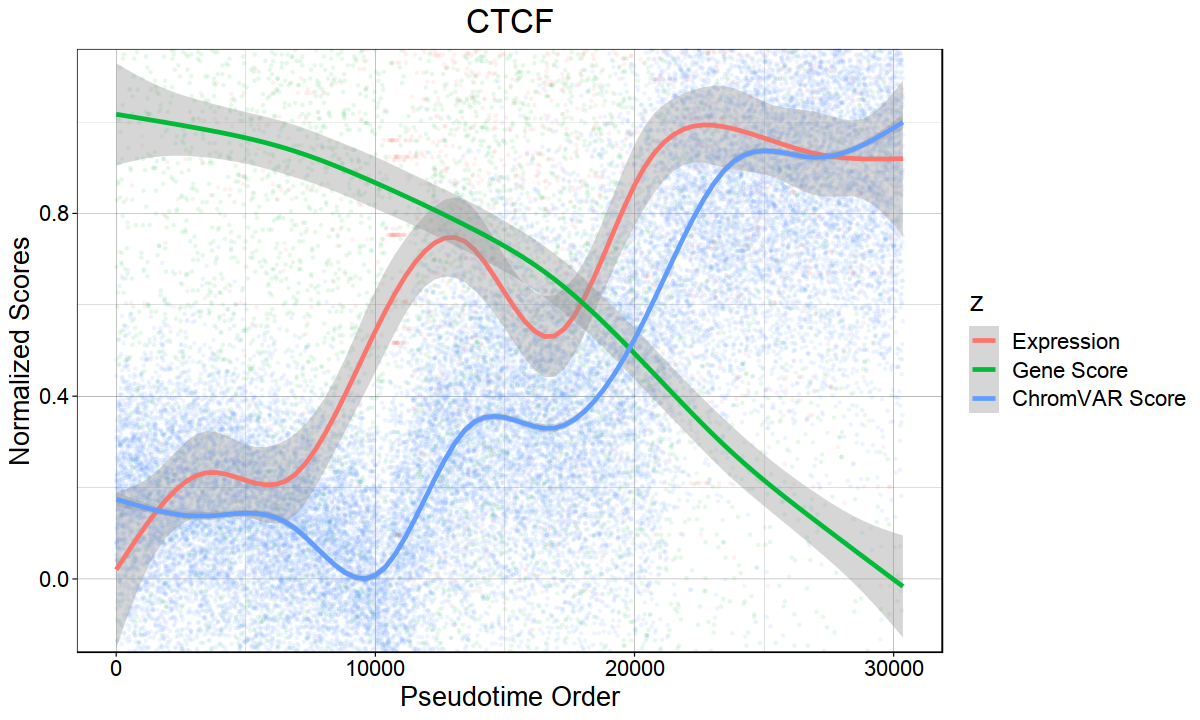

In [518]:
options(repr.plot.width = 10, repr.plot.height = 6)

integrated_plot <- ggplot(plot_df) + 
geom_point(aes (x=x,y=y,colour=z,group=z), stroke=0, size=1, alpha=0.1) +
geom_smooth(aes(x=x,y=y,colour=z, group=z)) +
xlab("Pseudotime Order") +
ylab("Normalized Scores") +
ggtitle(GENE) +
coord_cartesian(ylim=c(-0.1,1.1)) +
theme_linedraw() +
theme(plot.title = element_text(hjust = 0.5),
     text = element_text(size=16))

# wrap_plots(integrated_plot, day_bar, heights=c(5,1))
integrated_plot

### Expression vs Gene Score Correlations

In [354]:
gboth = intersect(rownames(rna), rownames(archr_gene_score_mat))

In [51]:
A = rna@assays$RNA@counts[gboth, RNA_SEL][, order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]
B = archr_gene_score_mat[gboth, ATAC_SEL][, order(pseudotime[ATAC_SEL,"dpt_pseudotime"])]

In [52]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [53]:
# sum every 100 along pseudotime
aggA = A[,1:31200] %*% create_sum_matrix(31200, 100)
aggB = B[,1:31200] %*% create_sum_matrix(31200, 100)
aggA = as.matrix(aggA)
aggB = as.matrix(aggB)

In [54]:
library(DESeq2)

In [85]:
# DESeq2 normalize
normaggA = log2(1+t(t(aggA)/estimateSizeFactorsForMatrix(aggA)))
normaggB = log2(1+t(t(aggB)/estimateSizeFactorsForMatrix(aggB)))

In [86]:
cA <-normaggA - rowMeans(normaggA)
cB <- normaggB - rowMeans(normaggB)
sA <- sqrt(rowMeans(cA^2))
sB <- sqrt(rowMeans(cB^2))

corrs = rowMeans(cA * cB) / (sA * sB)

In [340]:
corrs["CTCF"]

CTCF 
-0.2519012

In [87]:
corrs = corrs[!is.na(corrs)]

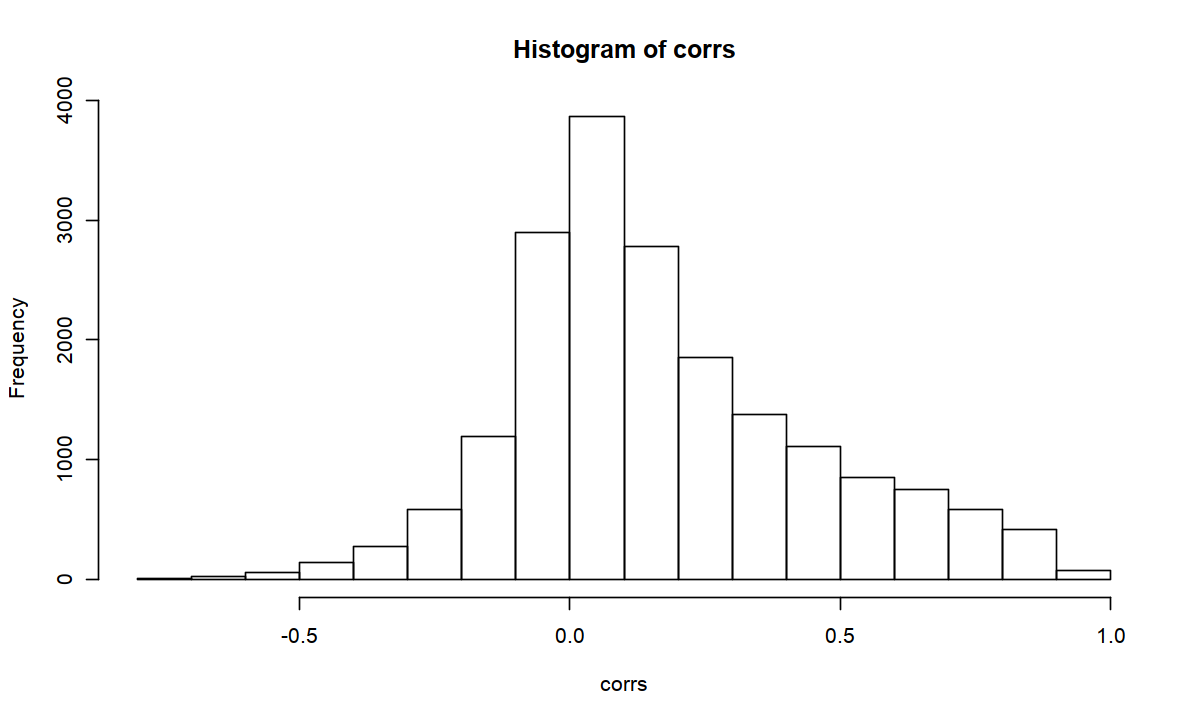

In [88]:
hist(corrs)

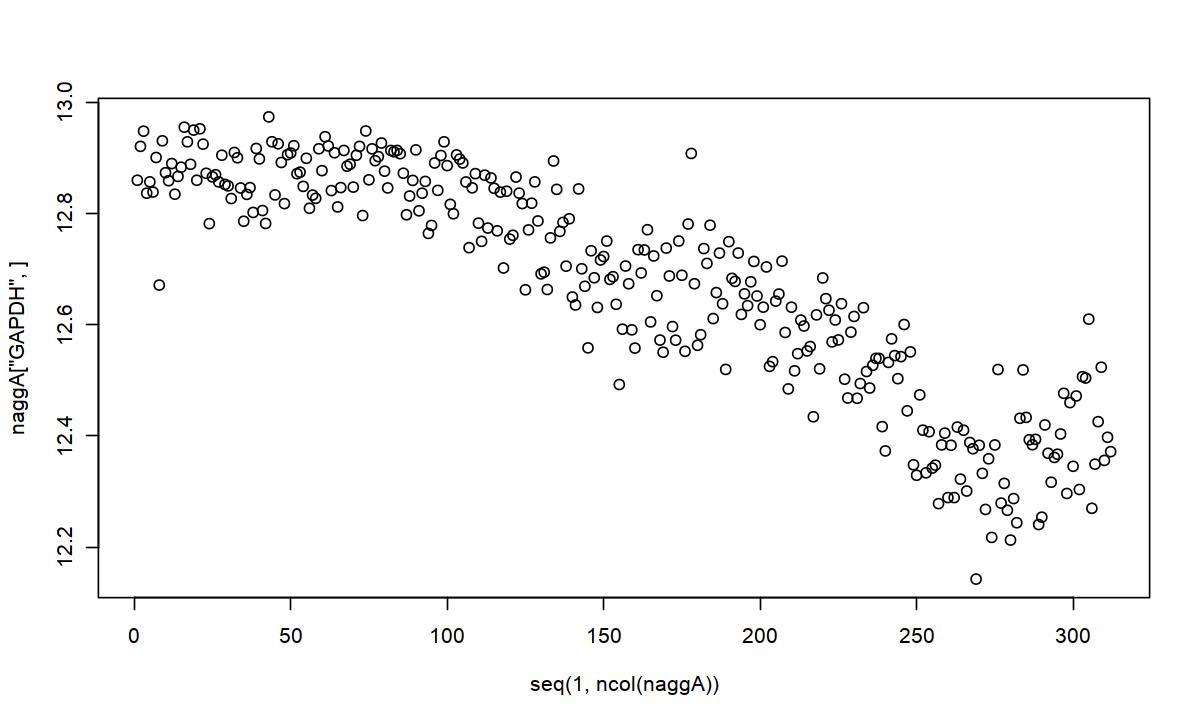

In [59]:
plot(seq(1,ncol(normaggA)), normaggA["GAPDH", ])

In [60]:
corrs[grep("SOX2", names(corrs))]

SOX2-OT      SOX2     QSOX2 SOX21-AS1     SOX21 
0.8044288 0.2697116 0.1615652 0.8477835 0.8616765

In [61]:
corrs[(order(corrs))][1:50]

NDUFS4          MYC        CMSS1       TBC1D5         CDT1      MMP24OS 
  -0.7761360   -0.7272205   -0.7250848   -0.6910949   -0.6876802   -0.6826552 
   LINC00545        WDR74       CAMTA1        GSTO2         RPL3       COMMD1 
  -0.6813743   -0.6624371   -0.6571132   -0.6526885   -0.6490460   -0.6453606 
      GTF3C1        NOP53       SMIM19        CORO7      POLDIP3         BOP1 
  -0.6405578   -0.6379775   -0.6368666   -0.6264224   -0.6221251   -0.6217547 
      ECHDC2         MIDN        DLEU1       DNAJC1         GYS1        CDCA4 
  -0.6208533   -0.6170860   -0.6163768   -0.6131601   -0.6109996   -0.6099263 
      SNRPD3        MRPL4     C12orf57     HOXB-AS1         SNX5       CADPS2 
  -0.6060484   -0.6041657   -0.6034747   -0.6020547   -0.5916873   -0.5912962 
        BRI3       EXOSC7       PRKAB2       SNHG16        UBE2S        GLRX5 
  -0.5905186   -0.5896050   -0.5858278   -0.5717947   -0.5711269   -0.5703343 
        MGMT        CNTLN   SUCLG2-AS1         IDNK       FBXL17         SARS 
  -0.5698824   -0.5659193   -0.5636320   -0.5618301   -0.5617653   -0.5615256 
        CMIP       GTPBP1       SEC23A        RNPS1       TOMM20     ARHGEF39 
  -0.5604265   -0.5552519   -0.5537690   -0.5521990   -0.5476614   -0.5467315 
TRAF3IP2-AS1         FIS1 
  -0.5464471   -0.5461806

In [62]:
names(corrs[(order(corrs))][1:200])[grep("^RP", names(corrs[(order(corrs))][1:200]))]

[1] "RPL3"   "RPS27"  "RPL37A" "RPS16"  "RPS9"   "RPS21"  "RPLP2"  "RPL7"  
 [9] "RPL41"  "RPL23A"

In [200]:
write.table(names(corrs[(order(corrs))][1:100])[normaggA[names(corrs[(order(corrs))][1:100]), 312]>normaggA[names(corrs[(order(corrs))][1:100]), 1]], 
            "tmp.txt", quote=F, row.names=F, col.names=F)

In [92]:
sum(normaggA[names(corrs[(order(corrs))][1:100]), 312]> normaggA[names(corrs[(order(corrs))][1:100]), 1])

[1] 71

In [71]:
corrs[rev(order(corrs))][1:10]

COL6A3       FOS     THBS1    SEMA6A      EGR1    COL6A2     GREM1    COL1A1 
0.9725415 0.9669856 0.9657313 0.9636175 0.9625606 0.9625132 0.9618802 0.9609644 
    LOXL2       TNC 
0.9599441 0.9581315

In [563]:
max(corrs, na.rm = T)

[1] 0.5067538

---

In [ ]:
sessionInfo()